# Establish Need for Improvement over Baselines.

## Q6: Can we improve the embedding of the GECCO model by embedding sub-group behavior rather than overall behavior?

In [83]:
"""
Externals
"""
import torch
import numpy as np
from novel_swarms.results.results import main as base_results
from novel_swarms.config.defaults import ConfigurationDefaults
from novel_swarms.novelty.NoveltyArchive import NoveltyArchive
from data.swarmset import SwarmDataset
from src.networks.network_wrapper import NetworkWrapper
from src.training.labels import LabelSet
from src.constants import SINGLE_SENSOR_WORLD_CONFIG, TWO_SENSOR_WORLD_CONFIG
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

"""
Import Pretrained Model
"""
arch = NoveltyArchive()
network = NetworkWrapper(output_size=5, margin=1.0, new_model=True)
network.load_from_path("../../../checkpoints/ensembles/01-27-23-BLH-HIL-G/0.pt")
network.eval_mode()

Adjusting learning rate of group 0 to 1.0000e-05.


In [85]:
"""
Load Data
"""
heterogeneous_dataset = SwarmDataset("../../../data/mrs-q6-samples", rank=0, color=True)
labels = LabelSet("../../../data/oracle/mrs-q4-labels.txt")

(50, 50, 3)
(50, 50, 3)


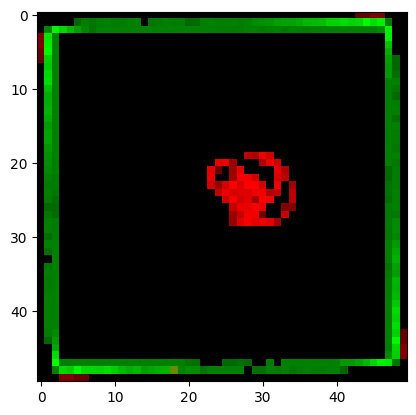

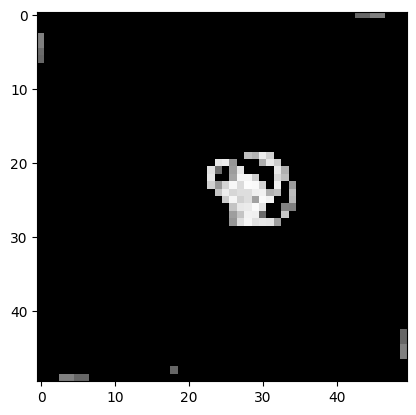

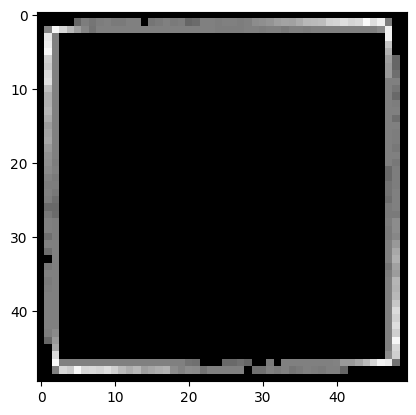

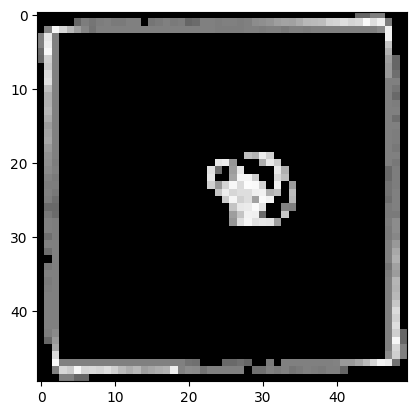

In [79]:
"""
Test Color Extraction via Numpy
"""

import matplotlib.pyplot as plt
import cv2

image = heterogeneous_dataset[5][0]
print(image.shape)

NOISE = 100
reduced_noise_r = image[:,:,0]
reduced_noise_g = image[:,:,1]

reduced_noise_r[reduced_noise_r < NOISE] = 0
reduced_noise_g[reduced_noise_g < NOISE] = 0

extracted_r = np.expand_dims(reduced_noise_r, axis=2)
extracted_g = np.expand_dims(reduced_noise_g, axis=2)
combined_r_g = np.bitwise_or(extracted_r, extracted_g)

rlayer = np.repeat(extracted_r, 3, axis=2)
glayer = np.repeat(extracted_g, 3, axis=2)
rgcombined = np.repeat(combined_r_g, 3, axis=2)

print(rlayer.shape)

plt.imshow(image)
plt.show()

plt.imshow(rlayer)
plt.show()

plt.imshow(glayer)
plt.show()

plt.imshow(rgcombined)
plt.show()


In [102]:
"""
Embed each layer separately into network
"""

def get_layer_embeddings(i):
    image = heterogeneous_dataset[i][0]

    NOISE = 100
    reduced_noise_r = image[:,:,0]
    reduced_noise_g = image[:,:,1]

    reduced_noise_r[reduced_noise_r < NOISE] = 0
    reduced_noise_g[reduced_noise_g < NOISE] = 0

    extracted_r = np.expand_dims(reduced_noise_r, axis=2)
    extracted_g = np.expand_dims(reduced_noise_g, axis=2)
    combined_r_g = np.bitwise_or(extracted_r, extracted_g)

    extracted_r = np.reshape(extracted_r, (1, 50, 50))
    extracted_g = np.reshape(extracted_g, (1, 50, 50))
    combined_r_g = np.reshape(combined_r_g, (1, 50, 50))

    r_image = np.expand_dims(extracted_r, axis=0)
    g_image = np.expand_dims(extracted_g, axis=0)
    c_image = np.expand_dims(combined_r_g, axis=0)

    r_embed = network.batch_out(r_image).detach().cpu().squeeze(dim=0).numpy()
    g_embed = network.batch_out(g_image).detach().cpu().squeeze(dim=0).numpy()
    c_embed = network.batch_out(c_image).detach().cpu().squeeze(dim=0).numpy()

    return r_embed, g_embed, c_embed


embeddings = []
for i in range(len(heterogeneous_dataset)):
    r, g, c = get_layer_embeddings(i)
    combined_vec = np.concatenate((r, g, c))
    # combined_vec = np.concatenate((combined_vec, heterogeneous_dataset[i][3]))
    embeddings.append(combined_vec)
embeddings = np.array(embeddings)

In [103]:
"""
Dimensionality Reduction (t-SNE)
"""
reduced = TSNE(
    n_components=2,
    learning_rate="auto",
    init="pca",
    perplexity=5,
    early_exaggeration=2
).fit_transform(embeddings)

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


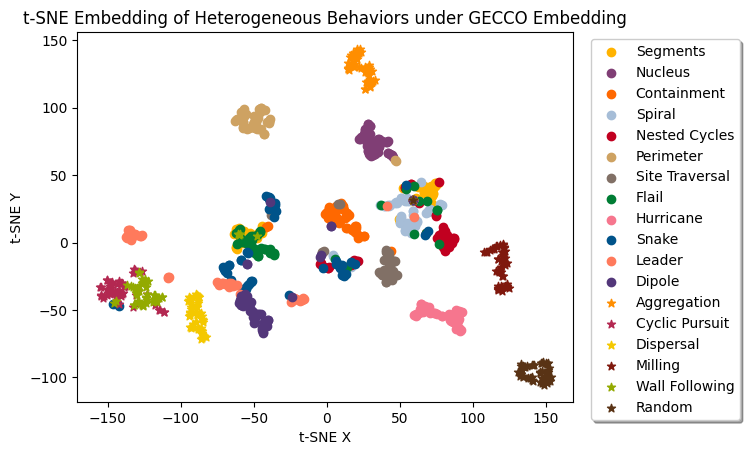

In [104]:
"""
Visualize (MatPlotLib)
"""
classes = ["Segments", "Nucleus", "Containment", "Spiral", "Nested Cycles", "Perimeter", "Site Traversal", "Flail", "Hurricane", "Snake", "Leader", "Dipole", "Aggregation", "Cyclic Pursuit", "Dispersal", "Milling", "Wall Following", "Random"]
lim = len(embeddings)
x = [reduced[i][0] for i in range(lim)]
y = [reduced[i][1] for i in range(lim)]
colors = labels.get_colors()

for _x, _y, _l, _c in zip(x, y, labels.get_labels(), colors):
    plt.scatter(_x, _y, c=[_c], cmap="rgb", marker="o" if _l < 12 else "*")

# Add Legend Labels (Hacky)
for i in range(len(classes)):
    plt.scatter(x[0], y[0], c=[list(labels.color_map.values())[i]], label=classes[i], marker="o" if i < 12 else "*")

plt.title("t-SNE Embedding of Heterogeneous Behaviors under GECCO Embedding")
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0),
          ncol=1, fancybox=True, shadow=True)
plt.show()